In [1]:
# Imports
import warnings; warnings.simplefilter("ignore")

from datetime import datetime, timedelta

from Database import db
 
import numpy as np
import pickle
import os
import re

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from keras.optimizers import RMSprop
from keras.models import Sequential, load_model, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, concatenate, SpatialDropout1D, GRU
from keras.layers import Dense, Flatten, Embedding, LSTM, Activation, BatchNormalization, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import keras.backend as K
from keras.utils import plot_model

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

Using TensorFlow backend.


In [2]:
# Options

stocks      = ['AMD', 'INTC', 'AAPL', 'AMZN', 'MSFT', 'GOOG']
all_sources = ['reddit', 'reuters', 'twitter', 'seekingalpha', 'fool', 'wsj', 'thestreet']

model_type  = 'multiheadlineclf'

doc2vec_options = dict(
    size=300, 
    window=10, 
    min_count=5, 
    workers=10,
    alpha=0.025, 
    min_alpha=0.025, 
    max_vocab_size=15000
)

keras_options = dict(
    epochs=200, 
    batch_size=32,
    verbose=0
)

tick_window = 7

test_cutoff = datetime(2018, 3, 20) # TODO use this for train/test split

In [3]:

def add_time(date, days):
    
    return (date + timedelta(days=days)).strftime('%Y-%m-%d')

def clean(sentence):
    
    sentence = sentence.lower()
    sentence = sentence.replace('-', ' ').replace('_', ' ').replace('&', ' ')
    sentence = ''.join(c for c in sentence if c in "abcdefghijklmnopqrstuvwxyz ")
    sentence = re.sub('\s+', ' ', sentence)
    
    return sentence.strip()

def make_doc_embeddings():
    
    print('Creating doc embeddings...')

    docs, labels = [], []
    
    class LabeledLineSentence:
        
        def __init__(self, docs, labels):
            self.docs = docs
            self.labels = labels
            
        def __iter__(self):
            for idx, doc in enumerate(self.docs):
                yield TaggedDocument(doc.split(), [self.labels[idx]]) # clean doc
    
    with db() as (conn, cur):
        
        for stock in stocks:
            
            ## Headline For Every Date ##
            
            cur.execute("SELECT DISTINCT date FROM headlines WHERE stock=? ORDER BY date ASC", [stock])
            dates = [date[0] for date in cur.fetchall()]
            new_dates = []
            for date in dates:
                d = datetime.strptime(date, '%Y-%m-%d')
                new_dates.append(add_time(d, -1))
                new_dates.append(add_time(d, +1))
            dates.extend(new_dates)
            
            for date in tqdm_notebook(dates, desc=stock):
                
                ## Collect Headlines ##
                
                event_date = datetime.strptime(date, '%Y-%m-%d')
                
                cur.execute("SELECT date, source, content FROM headlines WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date DESC", 
                            [stock, add_time(event_date, -12), date])
                headlines = [(date, source, content, (event_date - datetime.strptime(date, '%Y-%m-%d')).days) 
                                 for (date, source, content) in cur.fetchall() if content]
                
                if len(headlines) == 0:
                    continue
                
                ## Create training example ##
                    
                contents = [headline[2] for headline in headlines]

                doc = " **NEXT** ".join(contents)
                
                docs.append(doc)
                labels.append(stock + " " + date)
            
    doc_iter = LabeledLineSentence(docs, labels)
            
    vec_model = Doc2Vec(documents=doc_iter, **doc2vec_options)
    
    vectors = {stock: {} for stock in stocks}
    
    for label in labels:
        
        stock, date = label.split(" ")
        
        vectors[stock][date] = vec_model.docvecs[label]
                    
    return vec_model, vectors, (docs, labels)

def make_tick_data():
    
    print('Creating tick data...')
    
    tick_vecs = {stock: {} for stock in stocks}
    effect_vecs = {stock: {} for stock in stocks}
    
    with db() as (conn, cur):
        
        for stock in stocks:
            
            cur.execute("SELECT DISTINCT date FROM headlines WHERE stock=? ORDER BY date ASC LIMIT 1", [stock])
            start_date = cur.fetchall()[0][0]
            
            cur.execute("SELECT DISTINCT date FROM ticks WHERE stock=? AND date >= ? ORDER BY date ASC", [stock, start_date])
            dates = [date[0] for date in cur.fetchall()]
            
            for date in dates:
                
                event_date = datetime.strptime(date, '%Y-%m-%d') # The date of headline

                ## Find corresponding tick data ## 

                cur.execute("""SELECT open, high, low, adjclose, volume FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date DESC LIMIT 52""", 
                            [stock, 
                             add_time(event_date, -80), 
                             add_time(event_date, 0)])

                before_headline_ticks = cur.fetchall()

                if len(before_headline_ticks) < tick_window:
                    continue

                cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC LIMIT 1""", 
                            [stock, 
                            add_time(event_date, 1), 
                            add_time(event_date, 4)])

                after_headline_ticks = cur.fetchall()

                ## Create ##

                if len(after_headline_ticks) == 0:
                    continue

                window_ticks = np.array(list(reversed(before_headline_ticks[:tick_window]))) # Flip so in chron. order
                fifty_ticks = np.array(before_headline_ticks) # Use last 50 ticks to normalize

                previous_tick = before_headline_ticks[0][3]
                result_tick = after_headline_ticks[0][0]

                if previous_tick and result_tick:

                    window_ticks -= np.mean(fifty_ticks, axis=0)
                    window_ticks /= np.std(fifty_ticks, axis=0)
                    
                    if result_tick > previous_tick:
                        effect = [1., 0.]
                    else:
                        effect = [0., 1.]
                    
                    tick_vecs[stock][date] = window_ticks
                    effect_vecs[stock][date] = effect
                    
    return tick_vecs, effect_vecs


In [4]:

def merge_data(doc_vecs, tick_vecs, effect_vecs):
    
    print('Creating X, Y...')
    
    X, Y, test_indices = [], [], []
    
    for stock in stocks:
        
        for date, tick_vec in tick_vecs[stock].items():
            
            x = []
            y = effect_vecs[stock][date]
            
            event_date = datetime.strptime(date, '%Y-%m-%d')
            
            window_dates = [add_time(event_date, -i) for i in range(tick_window)]
            
            for i in range(tick_window):
                
                if window_dates[i] not in doc_vecs[stock]:
                    break
                    
                x_i = np.concatenate([tick_vec[i], doc_vecs[stock][window_dates[i]]])
                
                x.append(x_i)
                
            if len(x) == tick_window:
                
                X.append(x)
                Y.append(y)
                
                if event_date > test_cutoff:
                    test_indices.append(len(X) - 1)
        
    return np.array(X), np.array(Y), np.array(test_indices)


In [5]:

def split_data(X, Y, test_indices):
    """
    Splits X/Y to Train/Test
    """
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    train_indices = np.setdiff1d(indices, test_indices, assume_unique=True)
    
    trainX,  testX  = X[train_indices],  X[test_indices]
    trainY,  testY  = Y[train_indices],  Y[test_indices]
    
    return trainX, trainY, testX, testY


In [6]:

def correct_sign_acc(y_true, y_pred):
    """
    Accuracy of Being Positive or Negative
    """
    diff = K.equal(y_true > 0, y_pred > 0)
    
    return K.mean(diff, axis=-1)

def get_model():
    
    model_input = Input(shape=(tick_window, 305), name="Input")
    
    rnn = LSTM(500, return_sequences=True)(model_input)
    rnn = Dropout(0.3)(rnn)
    
    rnn = LSTM(300, return_sequences=False)(rnn)
    rnn = Dropout(0.3)(rnn)
    
    dense = Dense(300)(rnn)
    dense = Activation('selu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)
    
    dense = Dense(300)(dense)
    dense = Activation('selu')(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)
    
    dense = Dense(2)(dense)
    pred_output = Activation('softmax')(dense)
    
    model = Model(inputs=model_input, outputs=pred_output)
    
    model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['acc'])
    
    return model


In [7]:
# Load Data

if __name__ == "__main__":
    
    vec_model, doc_vecs, doc_data = make_doc_embeddings() #vec_model.docvecs.most_similar("INTC 2016-04-20")
    
    tick_vecs, effect_vecs = make_tick_data()
    
    X, Y, test_indices = merge_data(doc_vecs, tick_vecs, effect_vecs)
    
    trainX, trainY, testX, testY = split_data(X, Y, test_indices)
    
    print(trainX.shape, testY.shape)


Creating doc embeddings...


HBox(children=(IntProgress(value=0, description='AMD', max=5145), HTML(value='')))

HBox(children=(IntProgress(value=0, description='INTC', max=6162), HTML(value='')))

HBox(children=(IntProgress(value=0, description='AAPL', max=5553), HTML(value='')))

HBox(children=(IntProgress(value=0, description='AMZN', max=5922), HTML(value='')))

HBox(children=(IntProgress(value=0, description='MSFT', max=5919), HTML(value='')))

HBox(children=(IntProgress(value=0, description='GOOG', max=4782), HTML(value='')))


Creating tick data...
Creating X, Y...
(7759, 7, 305) (138, 2)


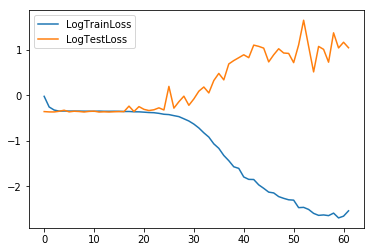

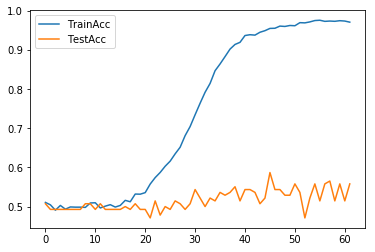

In [10]:
# TRAIN MODEL

if __name__ == "__main__":  

    ## Create Model ##
    
    model = get_model()
    
    monitor_mode = 'acc'
    
    tensorboard = TensorBoard(log_dir="logs/{}".format(datetime.now().strftime("%Y,%m,%d-%H,%M,%S,tick," + model_type)))
    e_stopping = EarlyStopping(monitor='val_loss', patience=50)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'), 
                                 monitor=monitor_mode,
                                 verbose=0,
                                 save_best_only=True)
    
    vec_model.save(os.path.join('..', 'models', 'doc2vec-' + model_type + '.doc2vec'))
    
    plot_model(model, to_file='model.png', show_shapes=True)
    
    ## Train ##
    
    history = model.fit(trainX,
                        trainY,
                        validation_data=(testX, testY),
                        callbacks=[e_stopping, tensorboard, checkpoint],
                        **keras_options)
    
    ## Display Train History ##
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['LogTrainLoss', 'LogTestLoss'])
    plt.show()
    
    plt.plot(history.history[monitor_mode])
    plt.plot(history.history['val_' + monitor_mode])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()


In [11]:
# AoC

if __name__ == "__main__":

    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import confusion_matrix
    
    try:
        
        actualY = testY
        predictY = model.predict(testX)
        
        print("ROC", roc_auc_score(actualY, predictY))
        
        print(confusion_matrix(testY[:, 0] > .75, predictY[:, 0] > .75))
        
    except NameError:
        
        print("Test Data and Model Required!")
    

ROC 0.5762605042016806
[[23 47]
 [15 53]]


In [ ]:
# # Predict (TEST)

# def predict(stock, model=None, toke=None, current_date=None, predict_date=None):
    
#     import keras.metrics
#     keras.metrics.correct_sign_acc = correct_sign_acc
    
#     if not model or not toke:
        
#         with open(os.path.join('..', 'models', 'toke2-tick.pkl'), 'rb') as toke_file:
#             toke = pickle.load(toke_file)
    
#         model = load_model(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'))
        
#     vocab_size = len(toke.word_counts)
        
#     if not current_date:
#         current_date = datetime.today()
        
#     if not predict_date:
#         predict_date = current_date + timedelta(days=1)
    
#     all_headlines, all_tick_hist = [], []
    
#     with db() as (conn, cur):
        
#         event_date = current_date
#         date = datetime.strftime(event_date, '%Y-%m-%d')
                
#         cur.execute("SELECT date, source, rawcontent FROM headlines WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date DESC", 
#                     [stock, add_time(event_date, -14), date])
#         headlines = [(date, source, clean(content), (event_date - datetime.strptime(date, '%Y-%m-%d')).days) 
#                         for (date, source, content) in cur.fetchall() if content]
                    
#         ## Find corresponding tick data ## 
                
#         cur.execute("""SELECT open, high, low, adjclose, volume FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date DESC""", 
#                     [stock, 
#                      add_time(event_date, -30 - tick_window), 
#                      add_time(event_date, 0)])
                
#         before_headline_ticks = cur.fetchall()[:tick_window]
#         actual_current = before_headline_ticks[0][3]
                
#         tick_hist = np.array(before_headline_ticks)
#         tick_hist -= np.mean(tick_hist, axis=0)
#         tick_hist /= np.std(tick_hist, axis=0)
                
#         ## Create training example ##

#         probs = [1 / (headline[3] + 1) for headline in headlines]
#         probs /= np.sum(probs)
                    
#         contents = [headline[2] for headline in headlines]

#         num_samples = len(contents) // sample_size

#         for i in range(num_samples):

#             indexes = np.random.choice(np.arange(len(headlines)), sample_size, replace=False, p=probs)
                    
#             sample = [headlines[i] for i in indexes]

#             all_headlines.append(sample)
#             all_tick_hist.append(tick_hist)
        
#         ## Process ##
    
#         encoded_headlines, toke = encode_sentences(all_headlines, tokenizer=toke, max_length=max_length)
        
#         tick_hists = np.array(all_tick_hist)
        
#         predictions = model.predict([encoded_headlines, tick_hists])[:, 0]
        
#         prices = predictions * 0.023 * actual_current + actual_current
        
#         return predictions, prices
    

In [ ]:
# # [TEST] Spot Testing

# if __name__ == "__main__":
    
#     ## **This Test May Overlap w/Train Data** ##
    
#     ## Options ##
    
#     stock = 'INTC'
#     current_date = '2018-03-07'
#     predict_date = '2018-03-08'
    
#     ## Run ##
    
#     predictions, prices = predict(stock, 
#                                   current_date=datetime.strptime(current_date, '%Y-%m-%d'), 
#                                   predict_date=datetime.strptime(predict_date, '%Y-%m-%d'))
    
#     ## Find Actual Value ##
     
#     with db() as (conn, cur):
    
#         cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC LIMIT 1""", 
#                         [stock, 
#                         add_time(datetime.strptime(predict_date, '%Y-%m-%d'), 0), 
#                         add_time(datetime.strptime(predict_date, '%Y-%m-%d'), 6)])

#         after_headline_ticks = cur.fetchall()
#         try:
#             actual_result = after_headline_ticks[0][0]
#         except:
#             actual_result = -1
            
#     ## Display ##
            
#     parse = lambda num: str(round(num, 2))
    
#     print("Predicting Change Coef: " + parse(np.mean(predictions)))
#     print("Predicting Price: " + parse(np.mean(prices)))
#     print("Actual Price: " + parse(actual_result))
            